In this demo, we compute sentence-level explanations for the Huggingface [`textattack/albert-base-v2-yelp-polarity`](https://huggingface.co/textattack/albert-base-v2-yelp-polarity) model, which is designed to perform sentiment analysis on paragraph-long reviews. If you come from the previous "NLP - Word" tutorial on computing word-level explanations (no worries if not), you may have realized that this problem could be solved by manually "sentencizing" the input text and defining each "sentence" as a "word." However, in this demo, we introduce the `TextSentenceMasker` class which handles this sentencization automatically, using the `spacy` package.

We first load required packages and the ALBERT model. Two classes are needed to compute the explanations. `BeamSearchExplainer` implements the beam search algorithm, and `*Masker` implements the feature masking. In this demo, we use `TextSentenceMasker` since we need to mask out individual sentences from a text input. The other demos showcase other `*Maskers`.

In [1]:
from solvex import BeamSearchExplainer, TextSentenceMasker
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

device = 'cuda' if torch.cuda.is_available() else 'cpu'
name = 'textattack/albert-base-v2-yelp-polarity'
tokenizer = AutoTokenizer.from_pretrained(name)
model = AutoModelForSequenceClassification.from_pretrained(name).to(device).eval()

The explainer expects the function to be explained in a particular format. Specifically, it takes in a list of `N` (full or masked) inputs, and returns a `numpy` array of shape `N x C` where `C` is the number of classes. The values of the array can be anything, but most commonly the class probability, which is what we are going to do here. In addition, when masking features (i.e., sentences) from a piece of text, `TextWordMasker` takes the text as a string and returns another string. Thus, `texts` is a list of strings.

In [2]:
def model_func(texts):
    tok = tokenizer(texts, return_tensors='pt', padding=True).to(device)
    with torch.no_grad():
        logits = model(**tok)['logits']
    probs = torch.nn.functional.softmax(logits, dim=-1).cpu().numpy()
    return probs

Now we are ready to explain! We instantiate the explainer, prepare the input, and call the `explain_instance` function. When removing a sentence, `TextWordMasker` simply deletes it from the paragraph. The `label` argument to `explain_instance` specifies which label we want to generate the explanation for. In our case, we want to explain the positive class, which is label `1`. If it is not specified, the label with the highest function value will be used.

In [3]:
text = ("Contrary to other reviews, I have zero complaints about "
        "the service or the prices. I have been getting tire service "
        "here for the past 5 years now, and compared to my experience "
        "with places like Pep Boys, these guys are experienced and know "
        "what they're doing. Also, this is one place that I do not feel "
        "like I am being taken advantage of, just because of my gender. "
        "Other auto mechanics have been notorious for capitalizing on "
        "my ignorance of cars, and have sucked my bank account dry. But "
        "here, my service and road coverage has all been well explained - "
        "and let up to me to decide. And they just renovated the waiting "
        "room. It looks a lot better than it did in previous years.")
masker = TextSentenceMasker()
explainer = BeamSearchExplainer(masker, f=model_func, beam_size=50, batch_size=16)
e = explainer.explain_instance(text, label=1)

100%|███████████████████████████████████| 7/7 [00:00<00:00, 11.58it/s]


The explanation `e` we get is a dictionary of keys `'exp'`, `'label'` and `'func_val`, of type `list`, `int` and `float` respectively, as printed out below.

In [4]:
print(e)

{'exp': [1.5, 4.5, -0.5, -1.5, 3.5, 0.5, 2.5], 'label': 1, 'func_val': 0.99981827}


Even better, all built-in `*Masker` classes include more user-friendly explanation displays, and the `TextSentenceMasker` class has three. They can be called with `masker.render_result`, using different `mode` parameters. The first one is console printing.

In [5]:
masker.render_result(text, e, mode='text', execute=True)

Explained label: 1
Function value for label 1: 1.000
Sentence feature attribution:
+--------------------------------------------------------------+------------+
| Sentence                                                     |   Attr val |
|--------------------------------------------------------------+------------|
| Contrary to other reviews, I have zero complaints about the  |        1.5 |
| service or the prices.                                       |            |
|--------------------------------------------------------------+------------|
| I have been getting tire service here for the past 5 years   |        4.5 |
| now, and compared to my experience with places like Pep      |            |
| Boys, these guys are experienced and know what they're       |            |
| doing.                                                       |            |
|--------------------------------------------------------------+------------|
| Also, this is one place that I do not feel like I am bein

The second one is color rendering.

In [6]:
masker.render_result(text, e, mode='color', execute=True)

It writes an HTML snippet to a file named `explanation.html`, which is rendered below.
<div style="border: solid; border-width: 1px; margin-top: 5px; margin-bottom: 5px; padding-left: 10px; padding-right: 10px; padding-bottom: 5px;">Explained label: 1<br>Function value for label 1: 1.000<br><pre style="white-space: pre-wrap;"><span style="background-color: rgb(224, 187, 178);">Contrary to other reviews, I have zero complaints about the service or the prices.</span> <span style="background-color: rgb(232, 119, 93);">I have been getting tire service here for the past 5 years now, and compared to my experience with places like Pep Boys, these guys are experienced and know what they're doing.</span> <span style="background-color: rgb(208, 212, 223);">Also, this is one place that I do not feel like I am being taken advantage of, just because of my gender.</span> <span style="background-color: rgb(185, 196, 228);">Other auto mechanics have been notorious for capitalizing on my ignorance of cars, and have sucked my bank account dry.</span> <span style="background-color: rgb(229, 141, 121);">But here, my service and road coverage has all been well explained - and let up to me to decide.</span> <span style="background-color: rgb(222, 209, 206);">And they just renovated the waiting room.</span> <span style="background-color: rgb(227, 163, 149);">It looks a lot better than it did in previous years.</span> </pre></div>
The last one is plotting.

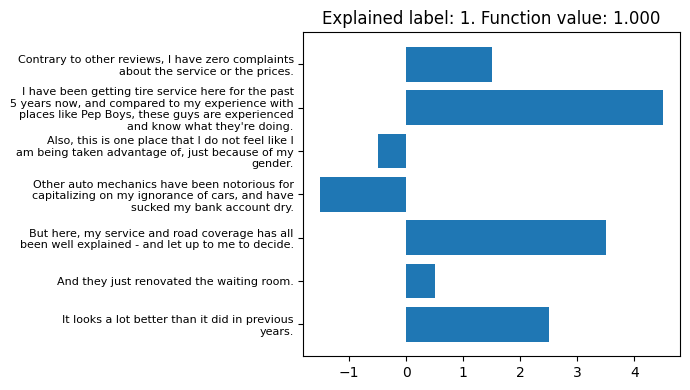

In [7]:
masker.render_result(text, e, mode='plot', execute=True)

And that's it! Want to learn more? Check out the other tabs for more use cases. If you want to gain a deeper understanding of the `*Masker` classes and implement your own, check out this jupyter notebook for an example where we build one from scratch and browse the documentations. Bugs? Suggestions? Questions? Ask away on [GitHub](https://github.com/YilunZhou/solvability-explainer)!